In [1]:
# Dependencies
import pandas as pd
import random
import numpy as np
import requests
import json
from citipy import citipy
import matplotlib.pyplot as plt
import time

# Google developer API key
from config import api_key

In [2]:
# generate a list of 500 random latitudes using the random.uniform(-180,180) function in the same loop
lat = np.arange(0,1000).astype('float')
for i in range(0,len(lat)):
    lat[i] = random.uniform(-90,90)

In [3]:
# generate a list of 500 random longitudes using the random.uniform(-180,180) function in the same loop
lng = np.arange(0,1000).astype('float')
for i in range(0,len(lng)):
    lng[i] = random.uniform(-180,180)

In [4]:
# use the lists above to create a DataFrame
cities = pd.DataFrame(list(zip(lat,lng)), columns=["Latitude", "Longitude"])

In [5]:
# use citipy to locate the nearest city to the lat,lng coordinates above
city_names = []
country_codes = []
for x in range(0,len(lat)):
    city = citipy.nearest_city(lat[x],lng[x])
    city_name = city.city_name
    country = city.country_code
    city_names.append(city_name)
    country_codes.append(country)

In [9]:
# add the city names to the DataFrame
cities["Nearest City"] = city_names
cities["Country Code"] = country_codes
cities.head()

,Latitude,Longitude,Nearest City,Country Code
0,-37.218573,75.525918,mahebourg,mu
1,8.121943,-102.200877,acapulco,mx
2,19.923920,34.431155,barbar,sd
3,78.193976,-102.132059,yellowknife,ca
4,-87.635882,-127.585977,rikitea,pf


In [24]:
# request weather data from openweathermap 
# (url = http://api.openweathermap.org/data/2.5/weather?q={city name},{country code}&APPID={your api key}
query_url = "http://api.openweathermap.org/data/2.5/weather?q="

units = 'imperial'

# collect data from api response in these lists
temp = []
humidity = []
cloudiness = []
wind_speed = []

# store names of cities with missing data in this list
missing_field = []

# counter for api allowance of 60 calls per minute
call_counter = 0

# this loops makes api requests from openweatherapi
for i in range(0,len(lat)):
    response = requests.get(f'{query_url}{city_names[i]},{country_codes[i]}&APPID={api_key}&units={units}')
    weather = response.json()
    call_counter +=1
    if call_counter == 59: # wait 60 seconds every 59 requests
        time.sleep(60)
        call_counter = 0
    try:
        temp.append(weather["main"]["temp"])
        humidity.append(weather["main"]["humidity"])
        cloudiness.append(weather["clouds"]["all"])
        wind_speed.append(weather["wind"]["speed"])
    except:
        missing_field.append(city_names[i])
        pass

In [25]:
# remove missing cities with missing fields from the DataFrame
cond = cities['Nearest City'].isin(missing_field)
weather_data = cities.drop(cities[cond].index)

In [26]:
# add columns for temperature, humidity, cloudiness, and wind speed to the DataFrame
weather_data["Temperature (F)"] = temp
weather_data["Humidity (%)"] = humidity
weather_data["Cloudiness (%)"] = cloudiness
weather_data["Wind Speed (mph)"] = wind_speed
weather_data.head()

,Latitude,Longitude,Nearest City,Country Code,Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph)
0,-37.218573,75.525918,mahebourg,mu,71.60,68,20,6.93
1,8.121943,-102.200877,acapulco,mx,89.60,62,40,8.05
3,78.193976,-102.132059,yellowknife,ca,68.00,40,75,21.92
4,-87.635882,-127.585977,rikitea,pf,76.03,84,27,14.83
5,75.948154,175.601976,leningradskiy,ru,45.72,78,74,7.72


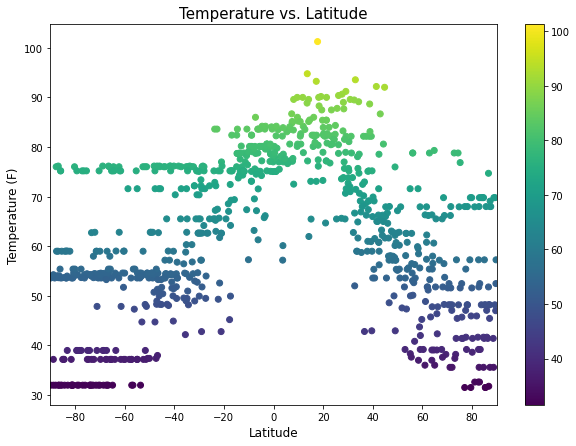

In [39]:
# make scatter plot of Temperature vs Lat
fig,ax = plt.subplots(figsize=(10,7))
chart = ax.scatter(weather_data["Latitude"],weather_data['Temperature (F)'],c=weather_data['Temperature (F)'],)
fig.colorbar(chart, ax=ax)
plt.xlabel("Latitude", fontsize=12)
plt.ylabel("Temperature (F)", fontsize=12)
plt.title("Temperature vs. Latitude", fontsize=15)
plt.xlim(-90,90)
plt.show()

## Observations
### Temperature shows a general warming trend towards the equator, but it is skewed toward the northern hemisphere.
### The hottest temperatures are recorded around 20 degrees latitude north.
### The temperature trends show scatter on both the norther and upper hemispheres, indicating that other factors also affect temperature. 

In [22]:
# make scatter plot of Humidity vs Lat
# comment on the graph
# make scatter plot of Cloudiness vs Lat
# comment on the graph
# make scatter plot of Wind Speed vs Lat
# comment on the graph
# add a column categorizing latitudes as northern or southern hemisphere and groupby
# plot the previous parameters for each group